In [1]:
!pip install rasterio

In [2]:
import rasterio as rio
from rasterio.plot import show
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score, accuracy_score, f1_score, precision_score, recall_score
import seaborn as sns
import pandas as pd
import time

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
class SlidingWindowSplitter:
    """Splitter for image/mask that takes evenly-spaced square patches.

    Attributes
    ----------
    patch_size : int
        Sidelength of extracted patches.
    stride : int
        Spacing between adjacent extractions.
    filters : list, optional
        All filters for patches that disallow certain criteria (default is
        None).
    """
    def __init__(self, patch_size, stride, filters=None):
        self.patch_size = patch_size
        self.stride = stride
        self.filters = filters

    def __call__(self, bands, mask):
        """Extracts evenly-spaced square patches from data.

        Parameters
        ----------
        bands : np.ndarray
            Band data for scene, aggregated into single 3D-array.
        mask : np.ndarray, bool
            One-hot encoded mask for scene.

        Returns
        -------
        bands_patches : list
            All extracted band data patches.
        mask_patches : list
            All extracted mask patches.
        patch_ids : list
            Identifiers for each patch based on x/y location.
        """
        if self.patch_size is not None:
            n_x = (bands.shape[0] - self.patch_size) // self.stride + 1
            n_y = (bands.shape[1] - self.patch_size) // self.stride + 1
            step_x = self.stride
            step_y = self.stride

            # pre-allocated for efficiency
            bands_patches = np.empty((n_x * n_y, self.patch_size, self.patch_size, bands.shape[-1]))
            mask_patches = np.empty((n_x * n_y, self.patch_size, self.patch_size,mask.shape[-1]))
            patch_ids = []
            num_valid_patches = 0
            for i in range(n_x):
                for j in range(n_y):
                    region = slice(i * step_x, i * step_x + self.patch_size), \
                             slice(j * step_y, j * step_y + self.patch_size), ...
                    bands_patch = bands[region]
                    mask_patch = mask[region]

                    if self.filters is not None:
                        if not all([filter(bands_patch, mask_patch) for filter in self.filters]):
                            continue

                    bands_patches[num_valid_patches, ...] = bands_patch
                    mask_patches[num_valid_patches, ...] = mask_patch
                    patch_ids.append(str(i).zfill(3) + str(j).zfill(3))
                    num_valid_patches += 1

            bands_patches = [bands_patches[i, ...] for i in range(num_valid_patches)]
            mask_patches = [mask_patches[i, ...] for i in range(num_valid_patches)]
        else:
            bands_patches = [bands]
            mask_patches = [mask]
            patch_ids = ['data']

        return bands_patches, mask_patches, patch_ids

In [5]:
def load_data(data_dir, mask_dir, file_name, mask_name, window):
    sentinel_data = []
    mask_data = []
    data_files = [f for f in os.listdir(data_dir) if f.startswith(file_name)]

    for filename in data_files:

        dirname = data_dir + filename
        with rio.open(dirname) as src:
            s_data = src.read()
            s_data = np.moveaxis(s_data, 0, -1)

        maskname = mask_dir + mask_name
        with rio.open(maskname) as src:
            mask = src.read()
            mask = np.moveaxis(mask, 0, -1)

        # Split sentinel data and mask
        splitter = SlidingWindowSplitter(window, window)
        sentinel_split, mask_split, patch_ids = splitter(s_data, mask)

        # Append splitted data into the array
        sentinel_data.append(sentinel_split)
        mask_data.append(mask_split)

    sentinel_data = np.array(sentinel_data)
    mask_data = np.array(mask_data)

    return sentinel_data, mask_data

data_dir = '/content/drive/MyDrive/Skripsi/Dataset/VVVH_Bands_10/'
mask_dir = '/content/drive/MyDrive/Skripsi/Dataset/Mask/'
window = 128
sentinel_data1, mask_data1 = load_data(data_dir, mask_dir, '1', 'Mask_1.tif', window)
sentinel_data2, mask_data2 = load_data(data_dir, mask_dir, '2', 'Mask_2.tif', window)
sentinel_data3, mask_data3 = load_data(data_dir, mask_dir, '3', 'Mask_3.tif', window)
sentinel_data4, mask_data4 = load_data(data_dir, mask_dir, '4', 'Mask_4.tif', window)

sentinel_data = np.concatenate((sentinel_data1, sentinel_data2, sentinel_data3, sentinel_data4))
mask_data = np.concatenate((mask_data1, mask_data2, mask_data3, mask_data4))

sentinel_data = np.reshape(sentinel_data, (sentinel_data.shape[0] * sentinel_data.shape[1], sentinel_data.shape[2], sentinel_data.shape[3], sentinel_data.shape[4]))
mask_data = np.reshape(mask_data, (mask_data.shape[0] * mask_data.shape[1], mask_data.shape[2], mask_data.shape[3], mask_data.shape[4]))

print(f"Loaded {len(sentinel_data)} sentinel data and {len(mask_data)} masks data.")

Loaded 2576 sentinel data and 2576 masks data.


In [6]:
import random

augmented_sentinel_data = []
augmented_mask_data = []

def random_flip_and_rotate(image, mask):
    # Randomly flip
    if random.random() > 0.5:
        image = np.flipud(image)  # Vertical flip
        mask = np.flipud(mask)

    if random.random() > 0.5:
        image = np.fliplr(image)  # Horizontal flip
        mask = np.fliplr(mask)

    # Randomly rotate by 90, 180, or 270 degrees
    rotations = random.choice([0, 1, 2, 3])  # 0: no rotation, 1: 90, 2: 180, 3: 270
    if rotations > 0:
        image = np.rot90(image, rotations, axes=(0, 1))  # Rotate along the spatial axes
        mask = np.rot90(mask, rotations)

    return image, mask

# Loop through original data to augment
for i in range(sentinel_data.shape[0]):
    img = sentinel_data[i]
    msk = mask_data[i]

    # Append the original data
    augmented_sentinel_data.append(img)
    augmented_mask_data.append(msk)

    # Augment the data
    aug_img, aug_msk = random_flip_and_rotate(img, msk)

    # Append the augmented data
    augmented_sentinel_data.append(aug_img)
    augmented_mask_data.append(aug_msk)

# Convert the augmented data back to numpy arrays
sentinel_data = np.array(augmented_sentinel_data)
mask_data = np.array(augmented_mask_data)

# Check the shape of the augmented dataset
print(f"Augmented data shape: {sentinel_data.shape}, augmented mask shape: {mask_data.shape}")

Augmented data shape: (5152, 128, 128, 12), augmented mask shape: (5152, 128, 128, 1)


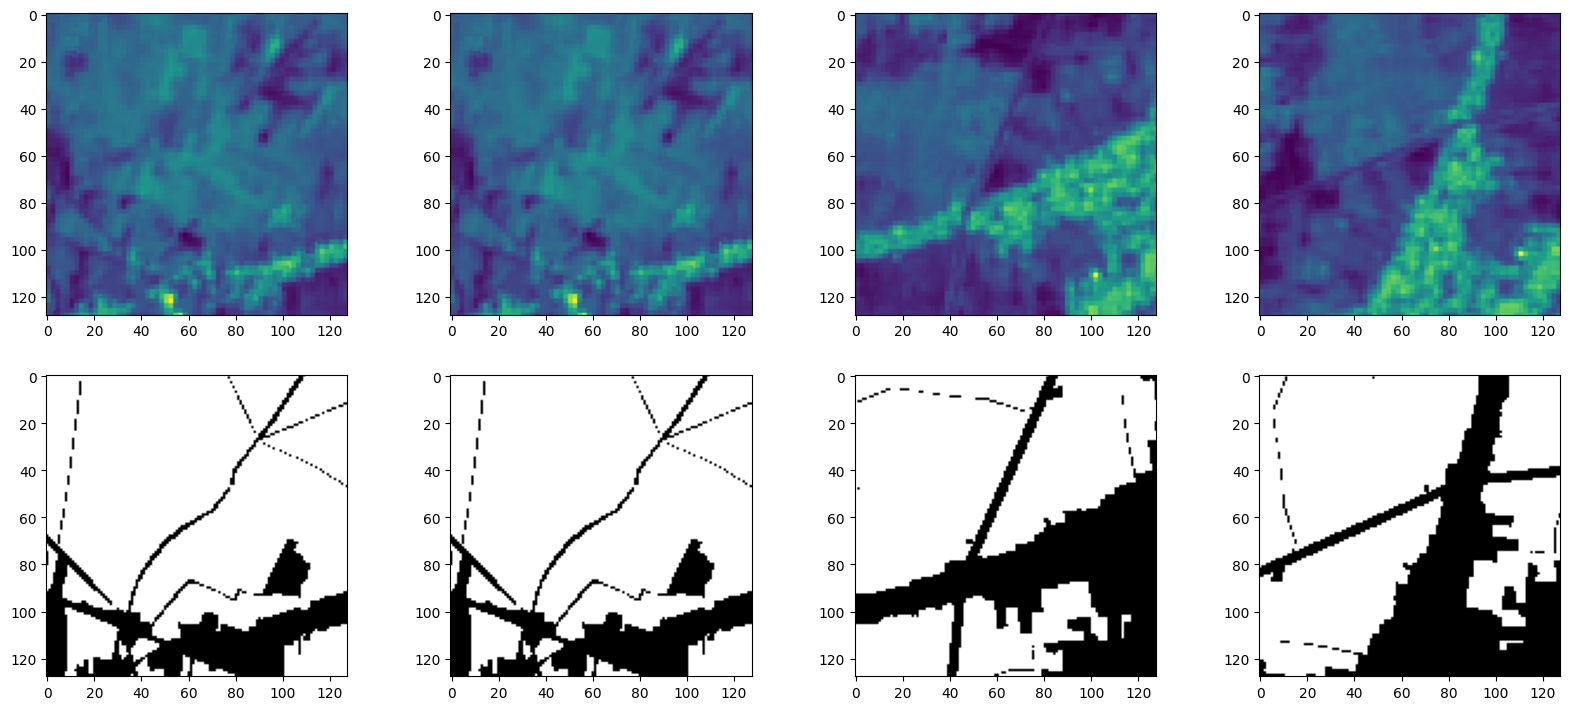

In [7]:
# Display example data loaded
plt.figure(figsize = (20, 18))
for i in range(4):
    plt.subplot(4,4,1 + i)
    plt.imshow(sentinel_data[i,:,:,-1].squeeze())
    plt.subplot(4,4,1 + i+4)
    plt.imshow(mask_data[i,:,:,0].squeeze(), cmap='gray')

In [8]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(sentinel_data, mask_data, test_size=0.2, random_state=42)
print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Training set size: 4121
Test set size: 1031


In [9]:
del sentinel_data1, sentinel_data2, sentinel_data3, sentinel_data4
del mask_data1, mask_data2, mask_data3, mask_data4
del sentinel_data
del mask_data

In [10]:
def transformer_block(x, num_heads, ff_dim, mlp_dim=3072, rate=0.1):
    skip_1 = x
    x = layers.LayerNormalization()(x)

    # Multi-Head Self Attention
    attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=ff_dim)(x, x)

    # Residual connection
    out1 = layers.Add()([attn_output, skip_1])
    skip_2 = out1

    # Layer Normalization
    out1_norm = layers.LayerNormalization()(out1)

    # MLP
    ffn_output = layers.Dense(mlp_dim, activation='gelu')(out1_norm)
    ffn_output = layers.Dropout(rate)(ffn_output)
    ffn_output = layers.Dense(x.shape[-1])(ffn_output)
    ffn_output = layers.Dropout(rate)(ffn_output)

    # Residual connection
    out2 = layers.Add()([ffn_output + skip_2])

    # Skip connection
    return out2

def conv_block(input_tensor, num_filters):
    x = layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(num_filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

def encoder_block(input_tensor, num_filters):
    x = conv_block(input_tensor, num_filters)
    p = layers.MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(input_tensor, skip_features, num_filters):
    x = layers.Conv2DTranspose(num_filters, (2,2), strides=2, padding='same')(input_tensor)
    x = layers.concatenate([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def transunet(input_shape, num_filters, num_heads=4, ff_dim=768, dropout_rate=0.1, num_layers=12):
    inputs = layers.Input(input_shape)

    # Encoder
    s1, p1 = encoder_block(inputs, num_filters[0])
    s2, p2 = encoder_block(p1, num_filters[1])
    s3, p3 = encoder_block(p2, num_filters[2])
    s4, p4 = encoder_block(p3, num_filters[3])

    # Bottleneck + Transformer Block
    for i in range(num_layers):
      b = transformer_block(p4, num_heads=num_heads, ff_dim=ff_dim, rate=dropout_rate)

    # Decoder
    d1 = decoder_block(b, s4, num_filters[3])
    d2 = decoder_block(d1, s3, num_filters[2])
    d3 = decoder_block(d2, s2, num_filters[1])
    d4 = decoder_block(d3, s1, num_filters[0])

    # Output
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(d4)

    model = Model(inputs, outputs, name="TransUNet")
    return model

In [11]:
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
num_filters = [32, 64, 128, 256]

optimizer = Adam(learning_rate=1e-4)
model = transunet(input_shape, num_filters)

lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-5)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
train_start_time = time.time()

#history = model.fit(X_train, y_train, epochs=100, batch_size=8, validation_split=0.2, verbose=2)
history = model.fit(X_train, y_train, epochs=150, batch_size=4, validation_split=0.25, callbacks=[lr_scheduler, early_stopping], verbose=2)

train_end_time = time.time()

Epoch 1/150
773/773 - 90s - 116ms/step - accuracy: 0.7761 - loss: 0.4762 - val_accuracy: 0.8364 - val_loss: 0.3667 - learning_rate: 1.0000e-04
Epoch 2/150
773/773 - 8s - 10ms/step - accuracy: 0.8239 - loss: 0.3977 - val_accuracy: 0.8769 - val_loss: 0.2913 - learning_rate: 1.0000e-04
Epoch 3/150
773/773 - 8s - 10ms/step - accuracy: 0.8442 - loss: 0.3672 - val_accuracy: 0.8751 - val_loss: 0.3107 - learning_rate: 1.0000e-04
Epoch 4/150
773/773 - 8s - 10ms/step - accuracy: 0.8585 - loss: 0.3425 - val_accuracy: 0.8946 - val_loss: 0.2643 - learning_rate: 1.0000e-04
Epoch 5/150
773/773 - 8s - 10ms/step - accuracy: 0.8685 - loss: 0.3199 - val_accuracy: 0.8875 - val_loss: 0.2831 - learning_rate: 1.0000e-04
Epoch 6/150
773/773 - 8s - 10ms/step - accuracy: 0.8740 - loss: 0.3083 - val_accuracy: 0.8952 - val_loss: 0.2610 - learning_rate: 1.0000e-04
Epoch 7/150
773/773 - 8s - 10ms/step - accuracy: 0.8808 - loss: 0.2956 - val_accuracy: 0.9005 - val_loss: 0.2516 - learning_rate: 1.0000e-04
Epoch 8/150

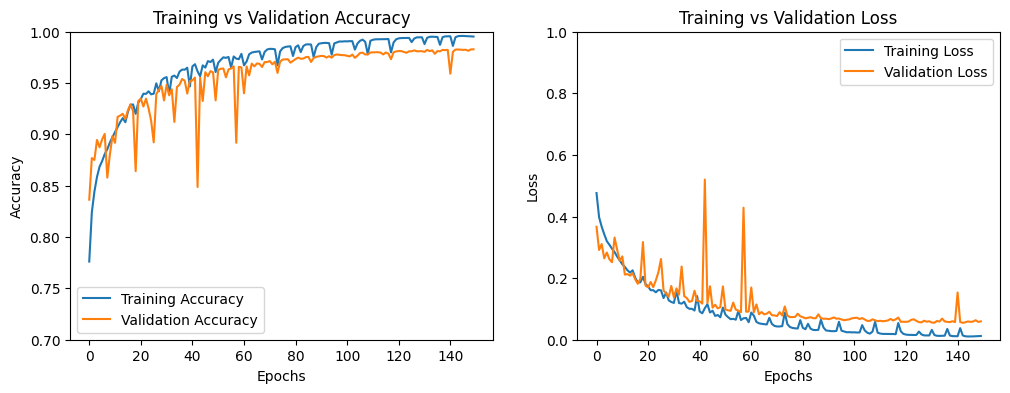

In [33]:
def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim(0.7, 1)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0, 1)
    plt.legend()

    plt.show()

plot_history(history)

In [14]:
# Generate predictions
test_start_time = time.time()
y_pred = model.predict(X_test)
test_end_time = time.time()

y_pred_labels = (y_pred >= 0.5).astype(int)
print(y_pred_labels.shape)
unique_values, counts = np.unique(y_pred_labels, return_counts=True)
print("Unique values:", unique_values)
print("Counts:", counts)

33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 254ms/step
(1031, 128, 128, 1)
Unique values: [0 1]
Counts: [9272125 7619779]


In [15]:
# Calculate training & testing time
training_time = train_end_time - train_start_time
testing_time = test_end_time - test_start_time

print(f"Training time: {training_time:.2f} seconds")
print(f"Testing time: {testing_time:.2f} seconds")

# Calculate total time
total_time = training_time + testing_time
print(f"Total time: {total_time:.2f} seconds")

Training time: 1273.02 seconds
Testing time: 16.98 seconds
Total time: 1290.00 seconds


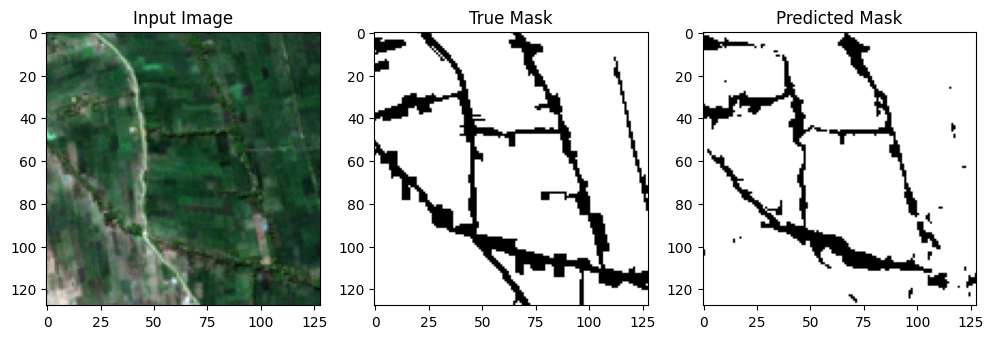

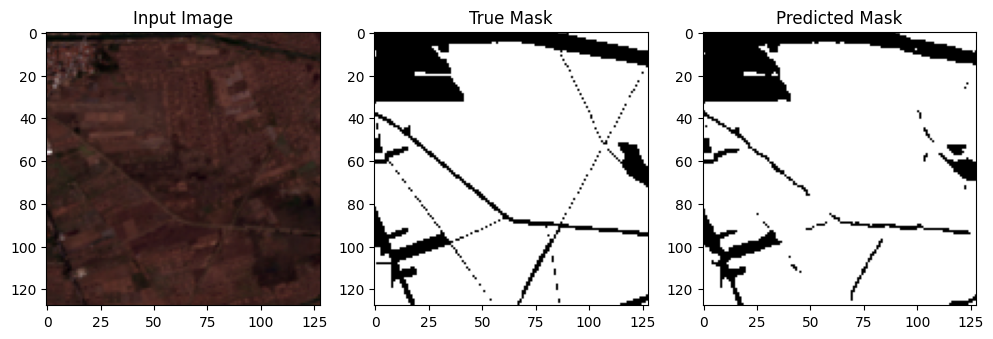

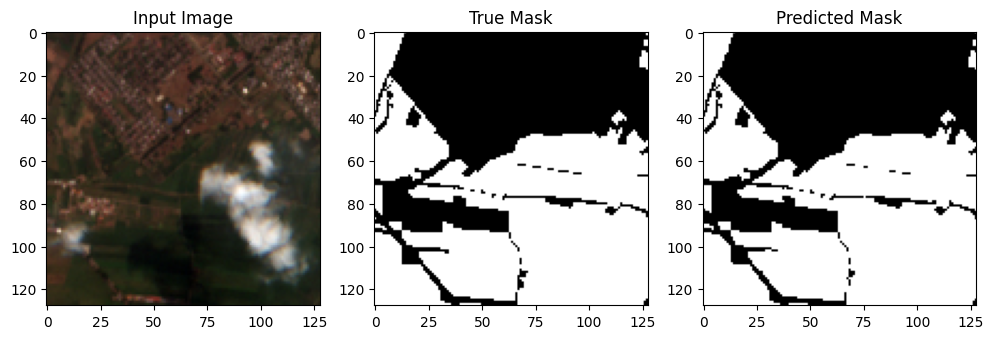

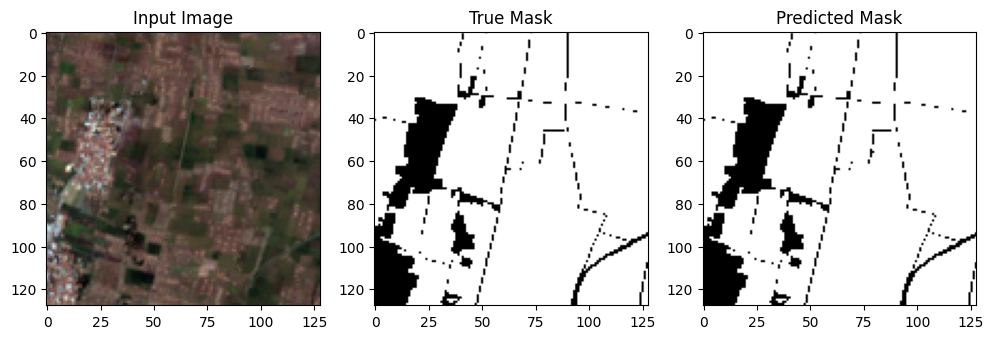

In [41]:
# Visualize some example predictions
def plot_sample_predictions(X, y_true, y_pred, sample_count=4):
    for i in range(sample_count):
        plt.figure(figsize=(12, 6))

        s_cropped = X[i,:,:,2:5]
        red=gammacorr(s_cropped[:,:,2])
        green=gammacorr(s_cropped[:,:,1])
        blue=gammacorr(s_cropped[:,:,0])
        red_n=normalize(red)
        green_n=normalize(green)
        blue_n=normalize(blue)
        rgb_composite= np.dstack((red_n, green_n, blue_n))

        plt.subplot(1, 3, 1)
        plt.title('Input Image')
        plt.imshow(rgb_composite.squeeze())

        plt.subplot(1, 3, 2)
        plt.title('True Mask')
        plt.imshow(y_true[i].squeeze(), cmap='gray')

        plt.subplot(1, 3, 3)
        plt.title('Predicted Mask')
        plt.imshow(y_pred[i].squeeze(), cmap='gray')

        plt.show()

# Plot some sample predictions
plot_sample_predictions(X_test, y_test, y_pred_labels)

In [17]:
# Extract the final accuracy and loss values
final_train_accuracy = history.history['accuracy'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

# Print the final results
print(f"Final Training Accuracy: {final_train_accuracy:.4f}")
print(f"Final Validation Accuracy: {final_val_accuracy:.4f}")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")

Final Training Accuracy: 0.9953
Final Validation Accuracy: 0.9829
Final Training Loss: 0.0121
Final Validation Loss: 0.0596


# Evaluation

In [18]:
def precision_score_(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    total_pixel_pred = np.sum(pred_mask)
    precision = np.mean(intersect/total_pixel_pred)
    return round(precision, 3)

def recall_score_(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    total_pixel_truth = np.sum(groundtruth_mask)
    recall = np.mean(intersect/total_pixel_truth)
    return round(recall, 3)

def accuracy(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    union = np.sum(pred_mask) + np.sum(groundtruth_mask) - intersect
    xor = np.sum(groundtruth_mask==pred_mask)
    acc = np.mean(xor/(union + xor - intersect))
    return round(acc, 3)

def dice_coef(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    total_sum = np.sum(pred_mask) + np.sum(groundtruth_mask)
    dice = np.mean(2*intersect/total_sum)
    return round(dice, 3) #round up to 3 decimal places

def iou(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    union = np.sum(pred_mask) + np.sum(groundtruth_mask) - intersect
    iou = np.mean(intersect/union)
    return round(iou, 3)

def metrics_table(mask, pred):
    metrics = {'Precision':[],'Recall':[],'Accuracy':[],'Dice':[],'IoU':[]}
    metrics['Precision'].append(precision_score_(mask, pred))
    metrics['Recall'].append(recall_score_(mask, pred))
    metrics['Accuracy'].append(accuracy(mask, pred))
    metrics['Dice'].append(dice_coef(mask, pred))
    metrics['IoU'].append(iou(mask, pred))
    df = pd.DataFrame.from_dict(metrics)
    df.columns = ['Precision', 'Recall', 'Accuracy', 'Dice', 'IoU']
    return df

metrics_table(y_test, y_pred_labels)

,Precision,Recall,Accuracy,Dice,IoU
0,0.974,0.985,0.981,0.979,0.959


In [19]:
y_test_flat = y_test.flatten()
y_labels_flat = y_pred_labels.flatten()

overall_accuracy = accuracy_score(y_test_flat, y_labels_flat)

print(f"Overall accuracy: {overall_accuracy:.4f}")

Overall accuracy: 0.9812


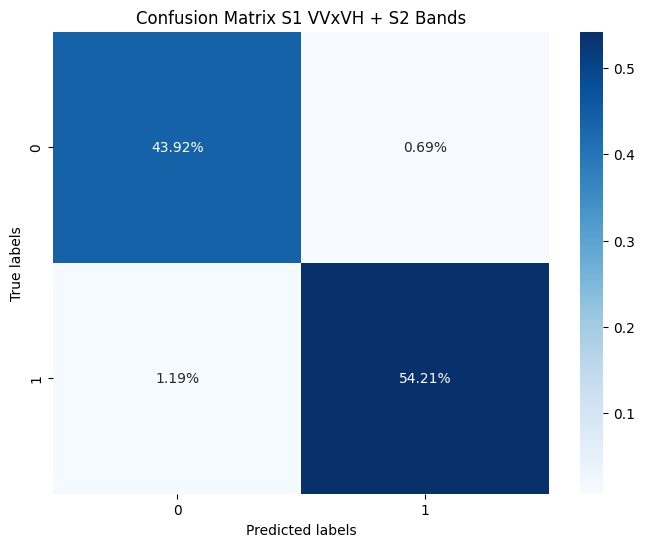

In [20]:
FP = len(np.where(y_pred_labels - y_test  == 1)[0])
FN = len(np.where(y_pred_labels - y_test  == -1)[0])
TP = len(np.where(y_pred_labels + y_test == 2)[0])
TN = len(np.where(y_pred_labels + y_test == 0)[0])
cmat = [[TP, FN], [FP, TN]]

plt.figure(figsize = (8, 6))
sns.heatmap(cmat/np.sum(cmat), cmap="Blues", annot=True, fmt = '.2%')
plt.title('Confusion Matrix S1 VVxVH + S2 Bands')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

# Prediction

In [21]:
def reconstruct_image(splitted_array):
    # Initialize the reconstructed image array
    reconstructed_image = np.zeros((512, 512, 1), dtype=splitted_array.dtype)

    # Define the size of the small images
    small_image_size = 128

    # Loop over the 16 small images
    for i in range(16):
        # Calculate the position of the small image in the original image
        row = (i // 4) * small_image_size
        col = (i % 4) * small_image_size

        # Place the small image in the correct position
        reconstructed_image[row:row + small_image_size, col:col + small_image_size, :] = splitted_array[i]

    return reconstructed_image

def normalize(band):
    band_min, band_max = (band.min(), band.max())
    return ((band-band_min)/((band_max - band_min)))

def gammacorr(band):
    gamma=25
    return np.power(band, 1/gamma)

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


Text(0.5, 1.0, 'Predicted')

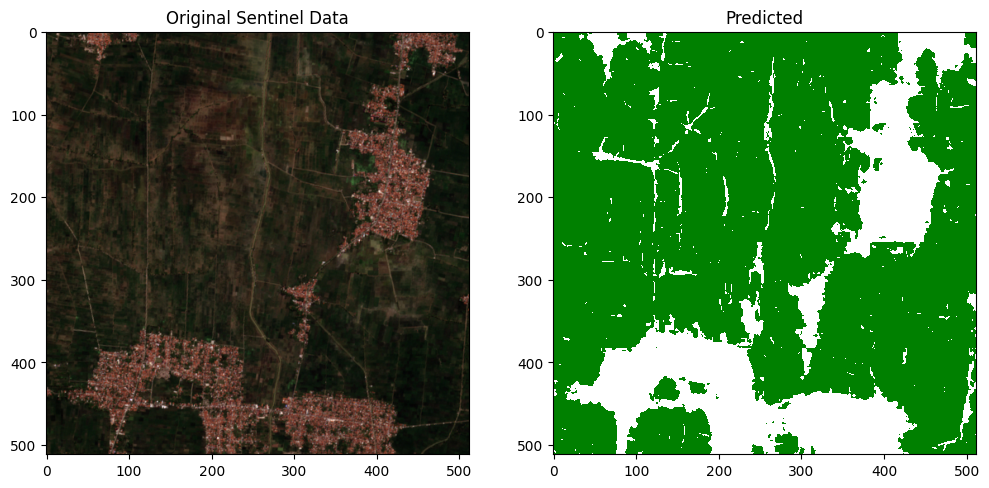

In [22]:
# Load Sentinel image data
with rio.open(data_dir + '5_20230724_20230720_MBN_5.tif') as src:
    s_data = src.read()
    s_data = np.moveaxis(s_data, 0, -1)
    profile = src.profile

# Load ground truth data
with rio.open(mask_dir + 'Mask_1.tif') as src:
    ground_truth = src.read()
    ground_truth = np.moveaxis(ground_truth, 0, -1)

splitter = SlidingWindowSplitter(window, window)
bands_patches, mask_patches, patch_ids = splitter(s_data, ground_truth)

bpatches = np.array(bands_patches)
mpatches = np.array(mask_patches)
ipatches = np.array(patch_ids)

# Generate predictions
prediction = model.predict(bpatches)
prediction_labels = (prediction >= 0.5).astype(int)

reconstructed_image = reconstruct_image(prediction_labels)
ground_truth_cropped = ground_truth[0:512, 0:512, :]
s_data_cropped = s_data[0:512, 0:512, 2:5]

red_b=gammacorr(s_data_cropped[:,:,2])
green_b=gammacorr(s_data_cropped[:,:,1])
blue_b=gammacorr(s_data_cropped[:,:,0])
red_bn=normalize(red_b)
green_bn=normalize(green_b)
blue_bn=normalize(blue_b)
rgb_composite_n= np.dstack((red_bn, green_bn, blue_bn))

# Define the colormap
cmap = ListedColormap(['white', 'green'])

# Show prediction
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.imshow(rgb_composite_n.squeeze())
plt.title('Original Sentinel Data')
plt.subplot(1,2,2)
plt.imshow(reconstructed_image.squeeze(), cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
plt.title('Predicted')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Text(0.5, 1.0, 'Predicted')

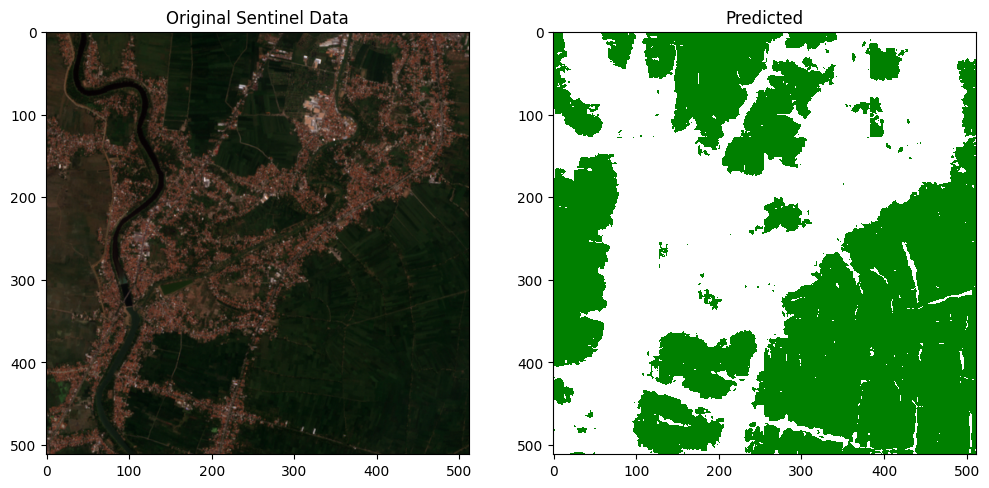

In [23]:
# Load Sentinel image data
with rio.open(data_dir + '6_20230817_20230814_MZU_5.tif') as src:
    s_data = src.read()
    s_data = np.moveaxis(s_data, 0, -1)
    profile = src.profile

# Load ground truth data
with rio.open(mask_dir + 'Mask_1.tif') as src:
    ground_truth = src.read()
    ground_truth = np.moveaxis(ground_truth, 0, -1)

splitter = SlidingWindowSplitter(window, window)
bands_patches, mask_patches, patch_ids = splitter(s_data, ground_truth)

bpatches = np.array(bands_patches)
mpatches = np.array(mask_patches)
ipatches = np.array(patch_ids)

# Generate predictions
prediction = model.predict(bpatches)
prediction_labels = (prediction >= 0.5).astype(int)

reconstructed_image = reconstruct_image(prediction_labels)
ground_truth_cropped = ground_truth[0:512, 0:512, :]
s_data_cropped = s_data[0:512, 0:512, 2:5]

red_b=gammacorr(s_data_cropped[:,:,2])
green_b=gammacorr(s_data_cropped[:,:,1])
blue_b=gammacorr(s_data_cropped[:,:,0])
red_bn=normalize(red_b)
green_bn=normalize(green_b)
blue_bn=normalize(blue_b)
rgb_composite_n= np.dstack((red_bn, green_bn, blue_bn))

# Define the colormap
cmap = ListedColormap(['white', 'green'])

# Show prediction
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.imshow(rgb_composite_n.squeeze())
plt.title('Original Sentinel Data')
plt.subplot(1,2,2)
plt.imshow(reconstructed_image.squeeze(), cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
plt.title('Predicted')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Text(0.5, 1.0, 'Predicted')

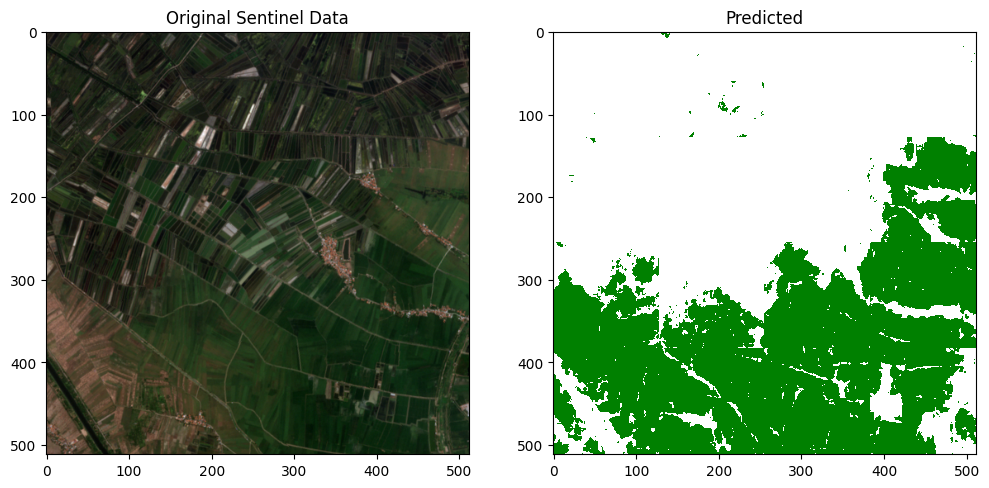

In [24]:
# Load Sentinel image data
with rio.open(data_dir + '7_20230817_20230814_MZU_5.tif') as src:
    s_data = src.read()
    s_data = np.moveaxis(s_data, 0, -1)
    profile = src.profile

# Load ground truth data
with rio.open(mask_dir + 'Mask_1.tif') as src:
    ground_truth = src.read()
    ground_truth = np.moveaxis(ground_truth, 0, -1)

splitter = SlidingWindowSplitter(window, window)
bands_patches, mask_patches, patch_ids = splitter(s_data, ground_truth)

bpatches = np.array(bands_patches)
mpatches = np.array(mask_patches)
ipatches = np.array(patch_ids)

# Generate predictions
prediction = model.predict(bpatches)
prediction_labels = (prediction >= 0.5).astype(int)

reconstructed_image = reconstruct_image(prediction_labels)
ground_truth_cropped = ground_truth[0:512, 0:512, :]
s_data_cropped = s_data[0:512, 0:512, 2:5]

red_b=gammacorr(s_data_cropped[:,:,2])
green_b=gammacorr(s_data_cropped[:,:,1])
blue_b=gammacorr(s_data_cropped[:,:,0])
red_bn=normalize(red_b)
green_bn=normalize(green_b)
blue_bn=normalize(blue_b)
rgb_composite_n= np.dstack((red_bn, green_bn, blue_bn))

# Define the colormap
cmap = ListedColormap(['white', 'green'])

# Show prediction
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.imshow(rgb_composite_n.squeeze())
plt.title('Original Sentinel Data')
plt.subplot(1,2,2)
plt.imshow(reconstructed_image.squeeze(), cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
plt.title('Predicted')

# Save Models

In [26]:
"""
model_dir = '/content/drive/MyDrive/Skripsi/Colab Notebooks/Saved Models/TransUNet_5(Good).keras'
model.save(model_dir)
"""